In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import scipy as scipy
from scipy.stats import ttest_ind

plt.style.use('ggplot')

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [2]:
# Считываем данные 
df = pd.read_csv( 'hw_bootstrap.csv', sep =';', decimal=',' )

# делим данные на группы
df_control = df.query('experimentVariant == "Control"').value
df_Treatment = df.query('experimentVariant == "Treatment"').value

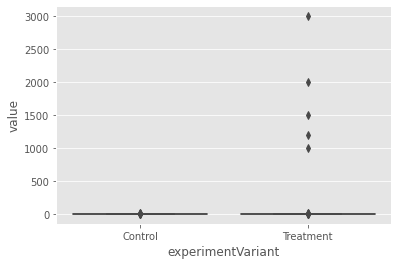

In [3]:
sns.boxplot( x = 'experimentVariant', y = 'value', data = df) # наблюдаем ошшибки в тестируемой группе

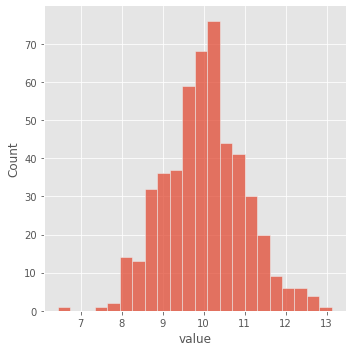

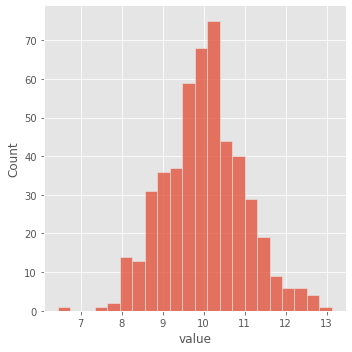

In [4]:
# Просматриваем распределения данных без выбросов (идентичны)

sns.displot(data = df_control)
sns.displot(data = df.query('value < 20 & experimentVariant == "Treatment"').value)

In [5]:
df_control.head(495) # смотрим 495 значений и видно что в разных группах они одинаковы

0      10.380495
1       9.546867
2      11.088215
3      10.147274
4       9.789808
         ...    
490    10.916229
491    11.160869
492     8.202518
493     9.782199
494    10.484967
Name: value, Length: 495, dtype: float64

In [6]:
df.query('value < 20 & experimentVariant == "Treatment"').value # смотрим значения без выбросов

500    10.380495
501     9.546867
502    11.088215
503    10.147274
504     9.789808
         ...    
990    10.916229
991    11.160869
992     8.202518
993     9.782199
994    10.484967
Name: value, Length: 495, dtype: float64

In [7]:
# в тестируемой (Treatment) группе есть 5 значений в 100 раз превышающие среднюю (больше выбросы) 
# если их убрать, то у нас получаются одинаковые выборки

# Для выполнения статических тестов оставяляю выбросы, для наблюдения значений разных тестов

In [8]:
# Выполнение бустрапа
#Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [9]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

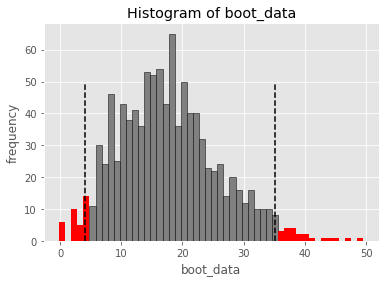

In [10]:
booted_data = get_bootstrap(df_Treatment, df_control) # в результате хранится разница двух распределений, ДИ и pvalue

In [11]:
booted_data["p_value"] # альфа (первым вписали тестируемую группу), Значение больше 0.025,  значительны

0.0312469024946068

In [12]:
booted_data["quants"] # ДИ. Значения не пересекает ноль, изменения в группах значительны ( но это из-за учета выбросов)

,0
0.025,4.010003
0.975,35.188578


In [13]:
# t-тест

In [14]:
scipy.stats.normaltest(df_control) # проверка нормальности распределения (распредельное нормальное)

NormaltestResult(statistic=2.9434587202565154, pvalue=0.22952820483957936)

In [15]:
scipy.stats.normaltest(df_Treatment) # проверка нормальности распределения (распределение ненормальное)

NormaltestResult(statistic=929.5157667884811, pvalue=1.439513760946726e-202)

In [16]:
ttest_ind(df_control, df_Treatment ) # Значение меньше 0.05, означает что статистически значимые измения (но это ложно)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

In [17]:
#U-теста Mann-Whitney (из-за выбросов лучше применять этот тест)

In [18]:
scipy.stats.mannwhitneyu(df_control, df_Treatment ) # больше 0.05, означает что статистически значимых изменений нет

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)